## Import

In [3]:
import pandas as pd 
from datetime import datetime  
import numpy as np 
import os 
import sys
import torch

# Personnal Import 
from utilities_DL import get_loss,choose_optimizer,data_generator,load_model
from DL_class import Trainer,PI_object
from PI import plot_bands_CQR
from config import get_config,get_config_embed,get_parameters,display_config

try:
    from plotting import visualize_prediction_and_embedding_space
    import matplotlib.pyplot as plt 
except : 
    print('matplotlib.pyplot is not available')
# ...

# Paths
folder_path = 'data/'
file_name = 'preprocessed_subway_15_min.csv'

## Load Raw Data and forbidden dates : 

In [4]:
#Init and load data: 
time_step_per_hour=4
H,W,D = 6,1,1
L = H+W+D 
step_ahead = 1

window_pred = np.arange(2*96)

# Load subway in data:
subway_in = pd.read_csv(folder_path+file_name,index_col = 0)
subway_in.columns.name = 'Station'
subway_in.index = pd.to_datetime(subway_in.index)

# Invalid dates : 
invalid_dates = pd.date_range(datetime(2019,4,23,14),datetime(2019,4,28,14),freq = f'{60/time_step_per_hour}min')

## Get Parameters

In [17]:
# Choose Model :
model_name = 'STGCN'  #CNN
single_station = False   # Quick Training if True

# Choose config 
config_Tembed = get_config_embed(Encoded_dims = [24,7],embedding_dim = 2,position = 'input')
config = get_config(model_name = model_name,other_params= {'seq_length':L})
#config = get_config(model_name = model_name,learn_graph_structure = True,other_params= {'seq_length':L})  # MTGNN

args = get_parameters(config)
args_embedding = get_parameters(config_Tembed,description = 'TimeEmbedding')



# Modification : 
args.calendar_class = 1



# Print config :
display_config(args,args_embedding)

Optimizer: adam 
 A specific LR by layer is used 
 Calendar class: 1 
 Quantile Method: weekday_hour 
 Encoding dimension: [24, 7] 
 Embedding dimension: 2 
 Position of the Embedding layer: input 


## Load Model

In [18]:
# Load dataset, dataloader, loss function, Model, Optimizer, Trainer 
df = subway_in[['Ampère Victor Hugo']] if single_station else subway_in
dataset,data_loader,dic_class2rpz,dic_rpz2class = data_generator(df,args,time_step_per_hour,step_ahead,H,D,W,invalid_dates)

# Quantile Loss
loss_function = get_loss(args.loss_function_type,args)

# Load Model
model = load_model(args,args_embedding).to(args.device)

# Config optimizer:
optimizer = choose_optimizer(model,args)

Ko: 8, enable padding: True
optimizer: adam


## Train and Calib Model 

In [19]:
# Train 
trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%

start training
epoch: 0 
 min\epoch : 0.23
Estimated time for training: 0.7min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

T embedding -> sum: -0.00023581611458212137, mean: -0.00023581611458212137


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


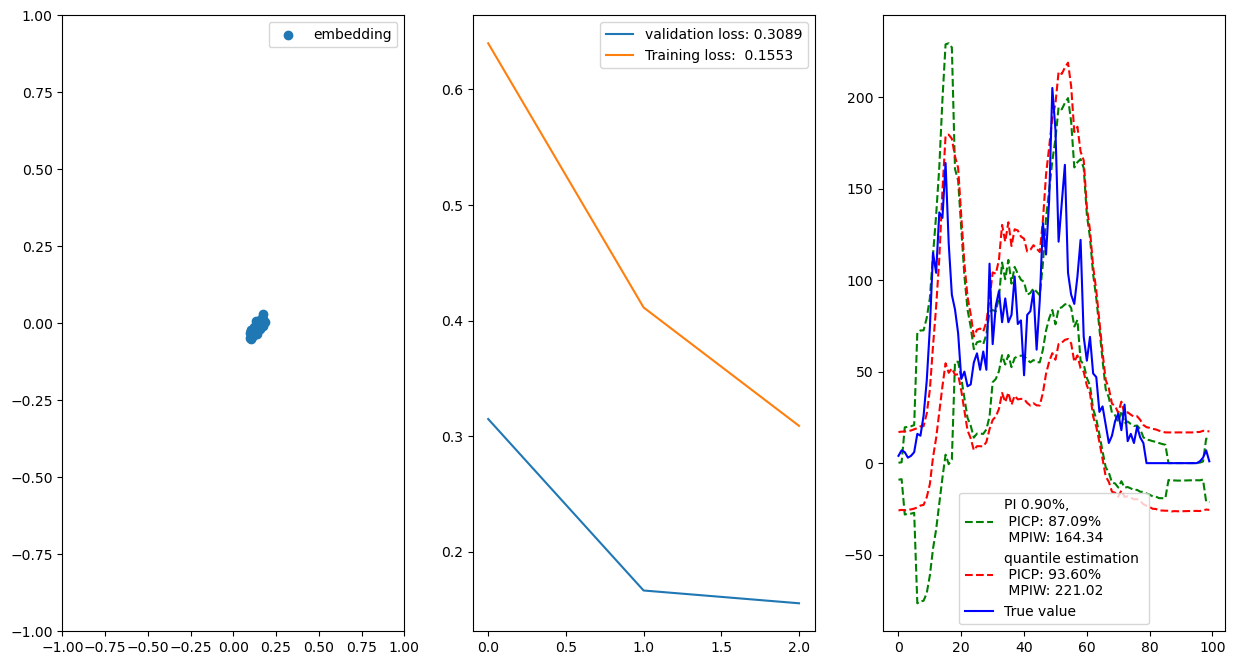

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.7min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

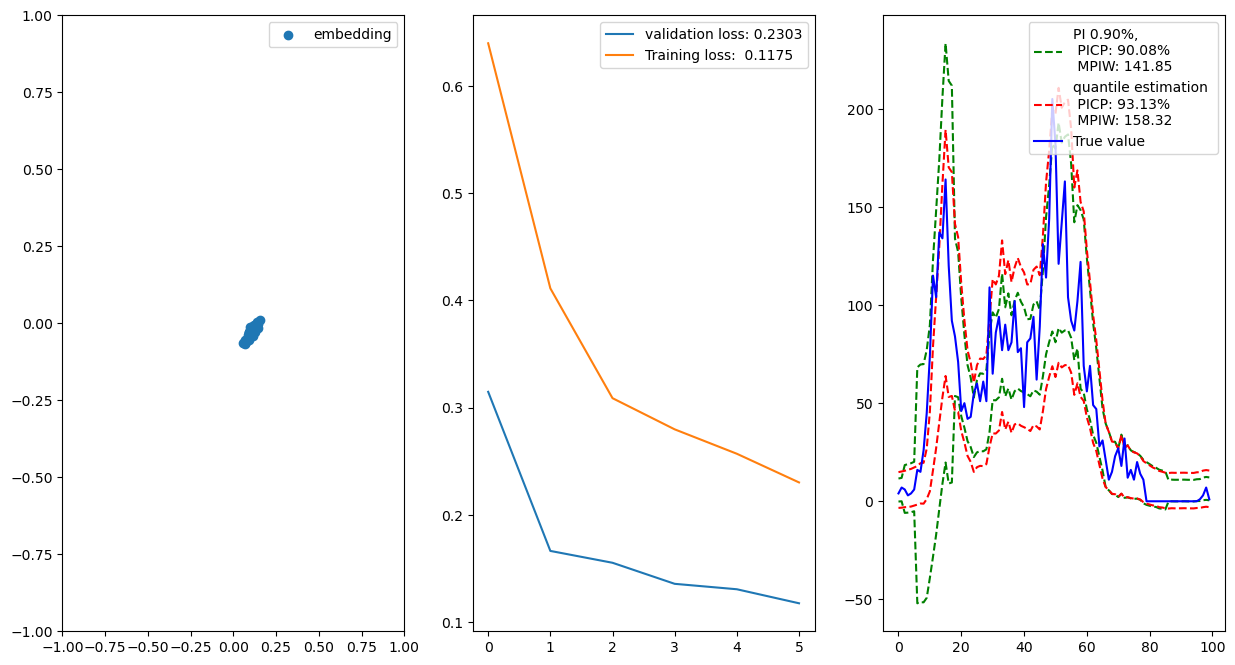

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.6min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

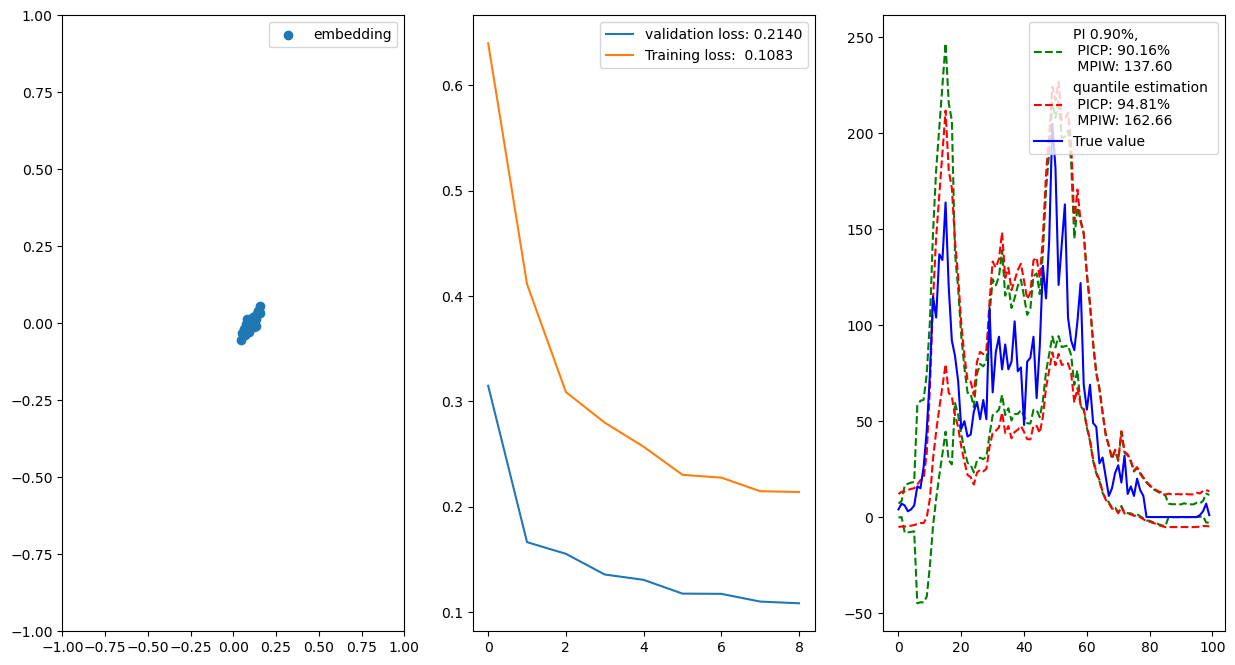

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.7min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

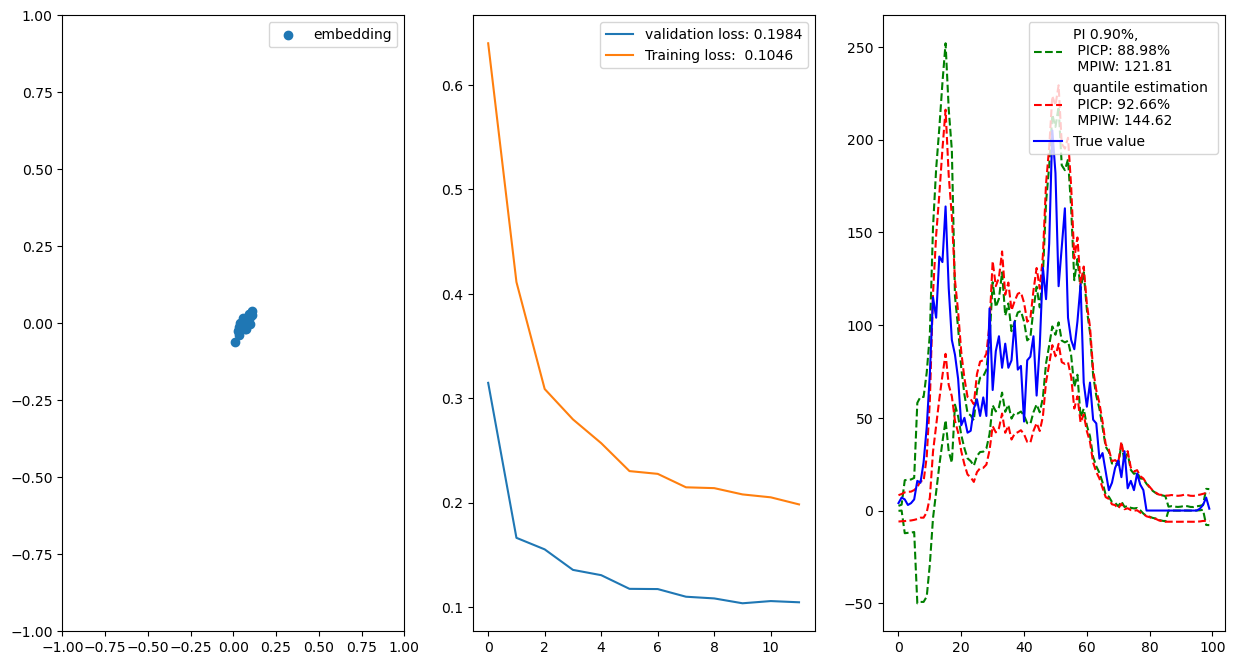

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.7min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

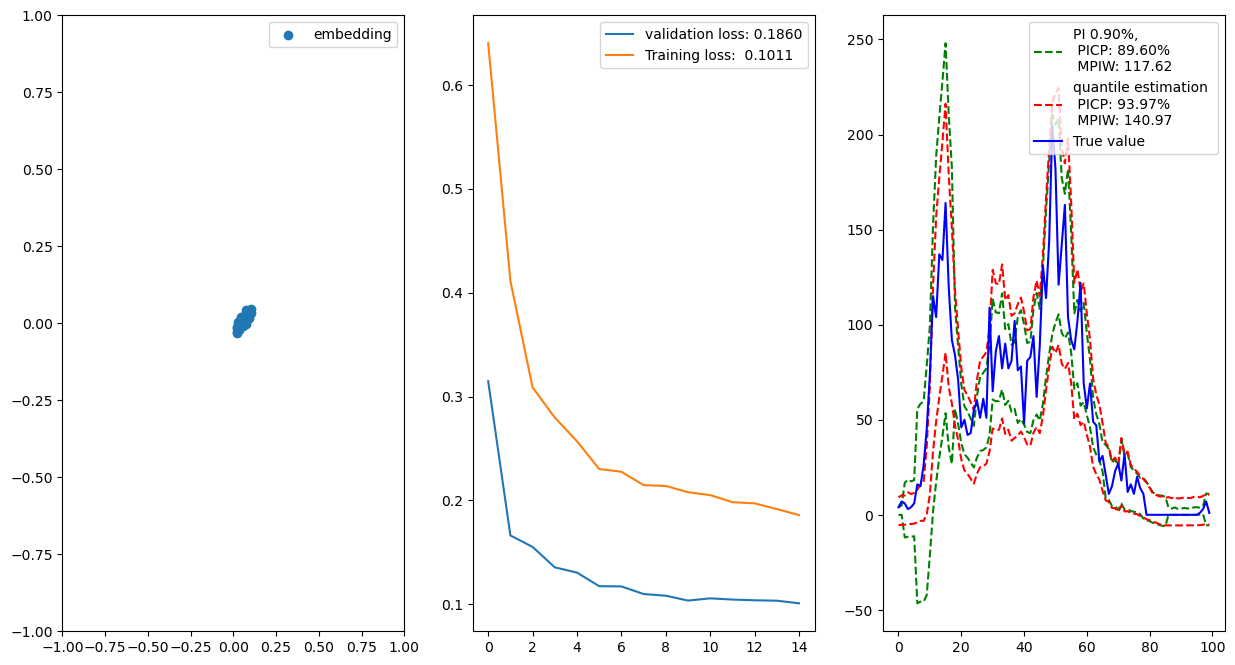

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.7min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

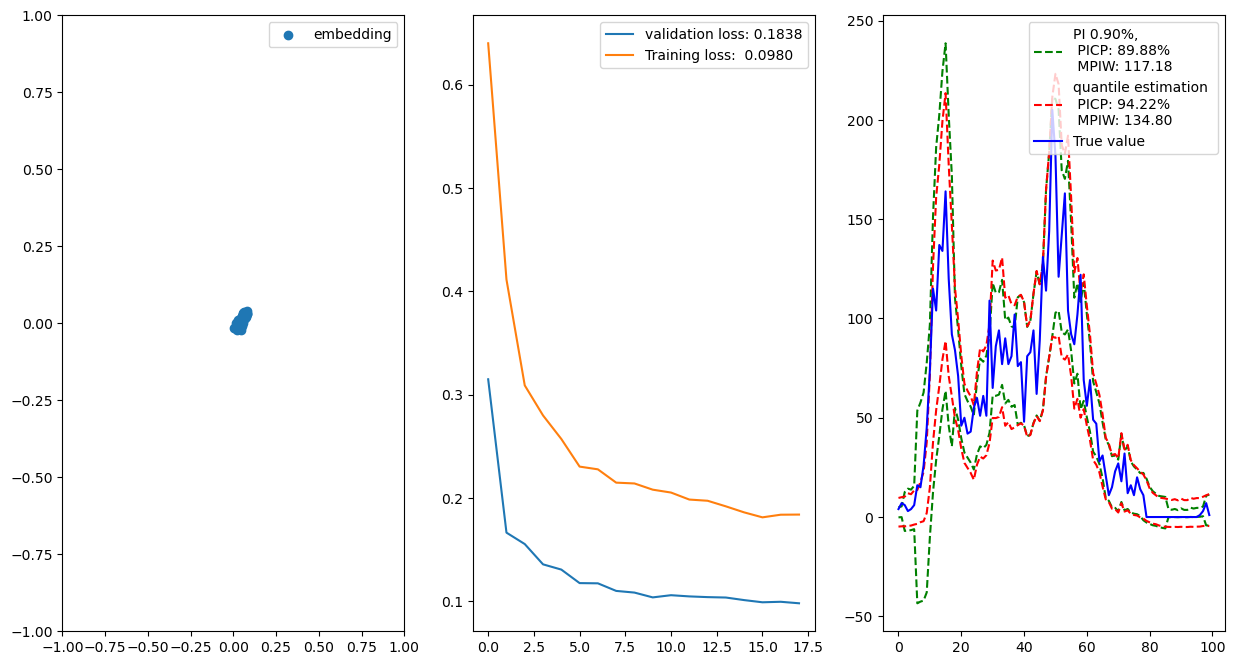

start training
epoch: 0 
 min\epoch : 0.21
Estimated time for training: 0.6min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

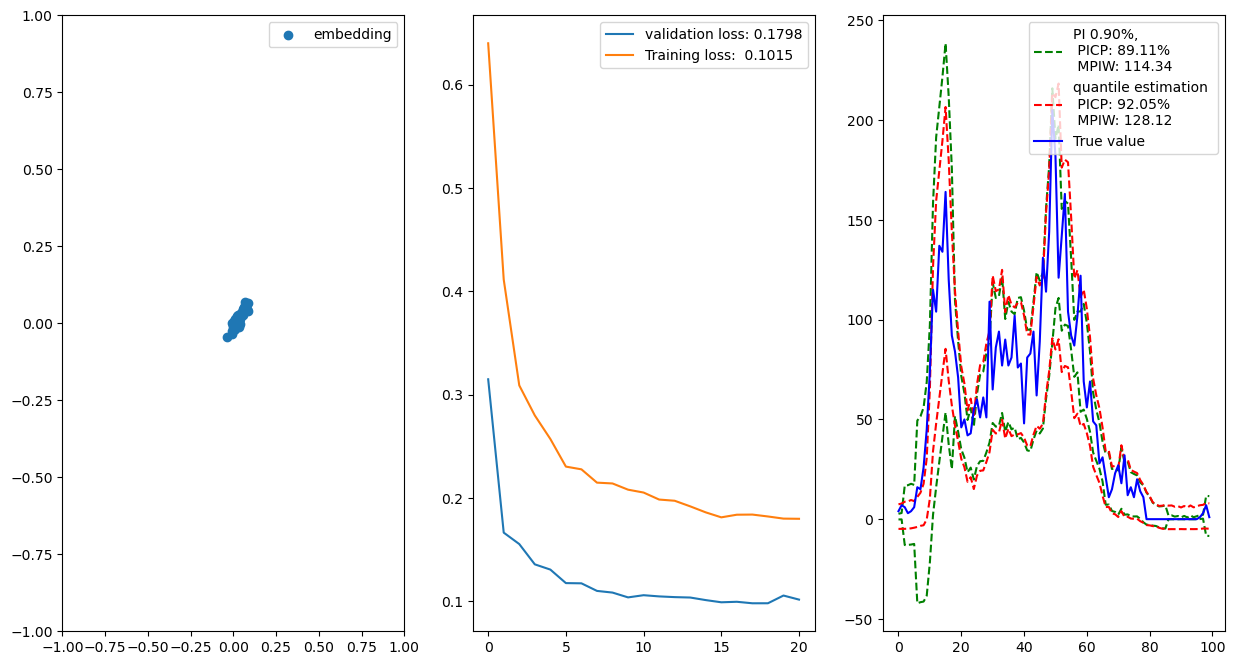

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.6min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

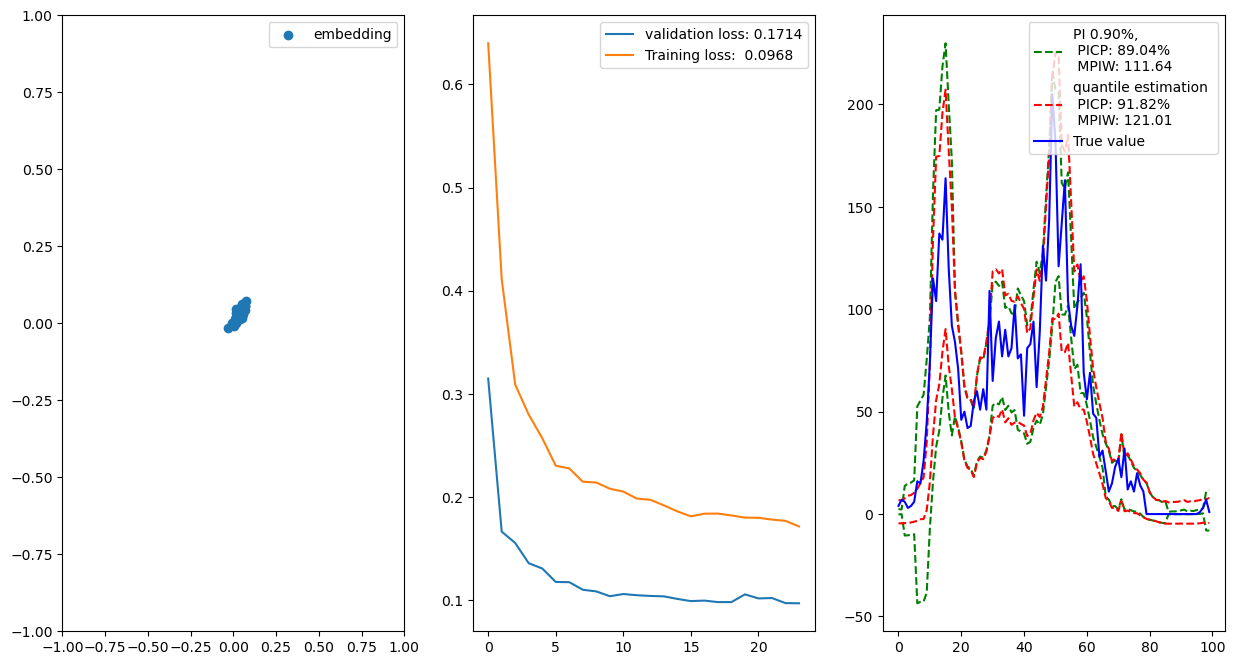

start training
epoch: 0 
 min\epoch : 0.21
Estimated time for training: 0.6min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

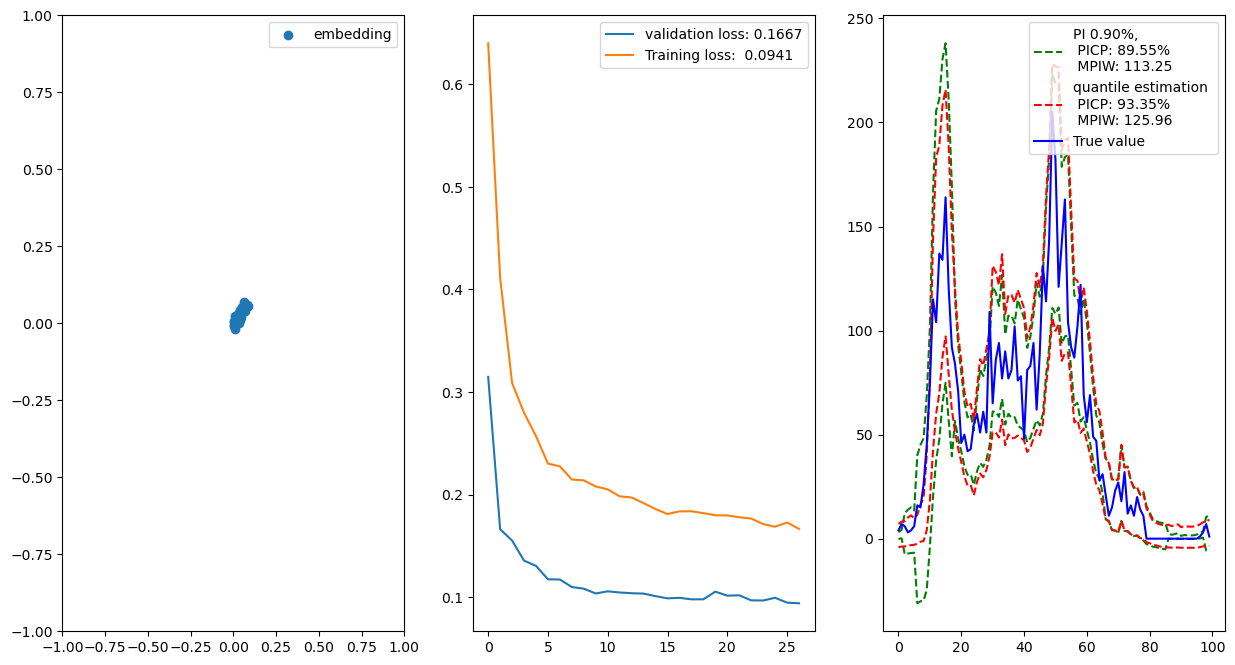

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.7min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

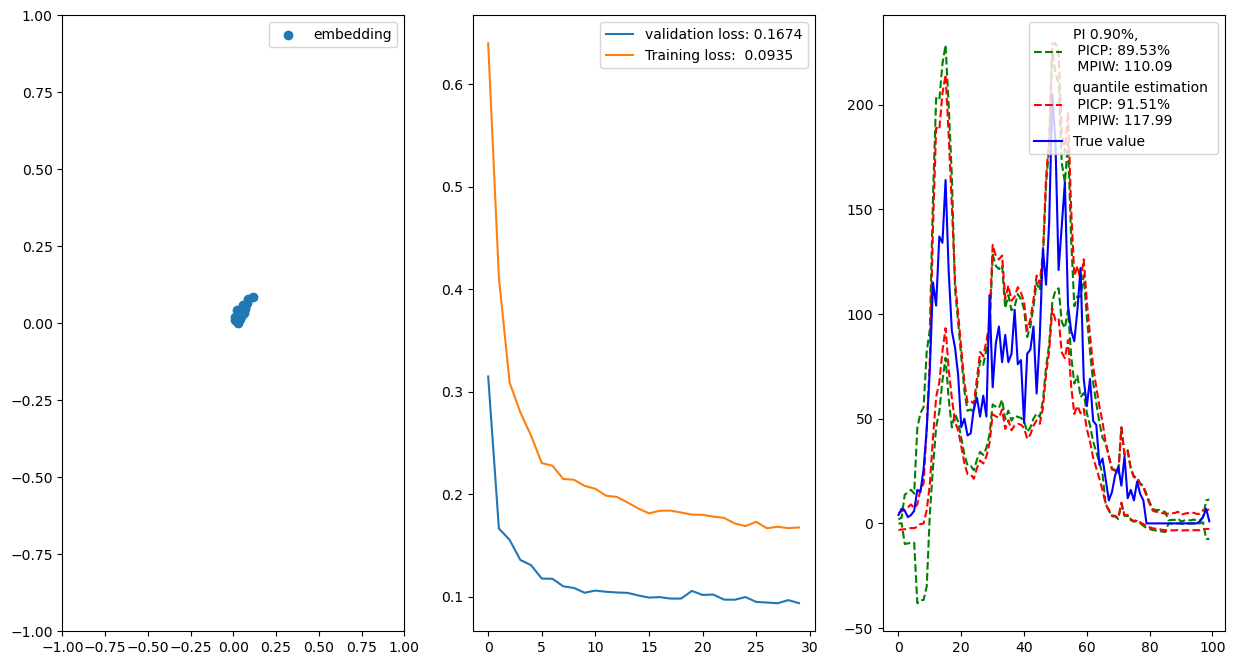

start training
epoch: 0 
 min\epoch : 0.22
Estimated time for training: 0.6min 
label 11.0 has only 9 elements in his class. We then use quantile order = 1
label 12.0 has only 5 elements in his class. We then use quantile order = 1
label 13.0 has only 16 elements in his class. We then use quantile order = 1
label 17.0 has only 18 elements in his class. We then use quantile order = 1
label 21.0 has only 9 elements in his class. We then use quantile order = 1
label 22.0 has only 8 elements in his class. We then use quantile order = 1
label 27.0 has only 18 elements in his class. We then use quantile order = 1
label 31.0 has only 12 elements in his class. We then use quantile order = 1
label 32.0 has only 13 elements in his class. We then use quantile order = 1
label 41.0 has only 9 elements in his class. We then use quantile order = 1
label 42.0 has only 11 elements in his class. We then use quantile order = 1
label 43.0 has only 17 elements in his class. We then use quantile order = 1
l

In [20]:
# Train and plot : 
for nb_visu in range(10):
    visualize_prediction_and_embedding_space(trainer,dataset,Q,args,args_embedding,plot2D = True,plot3D=False)
    trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
    Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%


## Plot Latent Space Bokeh 

In [107]:
def d2day(d):
    days = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
    return(days[d])


def hm2hour(hm):
    if hm[0][1] == 0:
        m1 = 'OO'
    else:
        m1 = str(hm[0][1])
    
    if hm[1][1] == 0:
        m2 = 'OO'
    else:
        m2 = str(hm[1][1])
    
    return f"{hm[0][0]}:{m1} - {hm[1][0]}:{m2}h"

# Get unique labels : 
data = [[x_b,y_b,t_b] for  x_b,y_b,t_b in data_loader['test']]
X_test,Y_test,T_test = torch.cat([x_b for [x_b,_,_] in data]),torch.cat([y_b for [_,y_b,_] in data]),torch.cat([t_b for [_,_,t_b] in data])
labels = T_test.unique().long()
# ...

# Plot Each Point : 
X,Y,Legend = [],[],[]
trainer.model.eval()
with torch.no_grad():
    for label in labels:
        x,y = trainer.model.Tembedding(label).cpu().detach().numpy()
        rpz = dic_class2rpz[label.item()]
        X.append(x)
        Y.append(y)
        Legend.append(f"{d2day(rpz[0][0])} {hm2hour(rpz[1])}")
# ...

In [108]:
from bokeh.plotting import figure, show, output_file, save,output_notebook
from bokeh.models import HoverTool, ColumnDataSource

# Assurons-nous que la sortie s'affiche dans le notebook
output_notebook()


# Création du ColumnDataSource à partir des données
source = ColumnDataSource(data=dict(x=X, y=Y, legend=Legend))

# Création de la figure
p = figure(title="Visualisation interactive avec Bokeh", x_axis_label='X', y_axis_label='Y')

# Ajout des points à la figure
p.circle('x', 'y', size=15, source=source)

# Configuration du HoverTool pour afficher la légende lors du survol
hover = HoverTool()
hover.tooltips =[("Legend", "@legend")] #[("Legend", "@legend"), ("(x,y)", "($x, $y)")]
p.add_tools(hover)

# Affichage de la figure

show(p)
output_file("rpz_time_embedding_CNN_ADAM_W.html")
save(p)

Loading BokehJS ...

'/Users/romainrochas/Desktop/Codes/Cleaned_Code/prediction validation/rpz_time_embedding_CNN_ADAM_W_2.html'

In [9]:
config = get_config(model_name = 'CNN')

config['conformity_scores_type'] = 'max_residual' 
config['seq_length'] = L

args = get_parameters(config)
args.epochs = 100

# Load train and calib model 
print(f"Type of model: {args.model_name} \n Loss function type: {args.loss_function_type} \n Quantile Method : {args.quantile_method} \n Calendar Class: {args.calendar_class} \n")
(dataset,U,Utarget) = load_normalized_dataset(subway_in,time_step_per_hour,args.train_prop,step_ahead,H,D,W,invalid_dates)
time_slots_labels,dic_class2rpz,dic_rpz2class = get_time_slots_labels(dataset,type_class= args.calendar_class)
data_loader_obj = DictDataLoader(U,Utarget,args.train_prop,args.valid_prop,validation = 'classic', shuffle = True, calib_prop=args.calib_prop, time_slots = time_slots_labels)
data_loader = data_loader_obj.get_dictdataloader(args.batch_size)

# Quantile Loss
quantiles = torch.Tensor([args.alpha/2,1-args.alpha/2]).to(args.device)
assert args.out_dim == len(quantiles), "Output dimension doesn't match with the number of estimated quantiles"
loss_function = get_loss(args.loss_function_type,quantiles)

# Load model : 
model = load_model(args,args_embedding)
model.to(args.device)
optimizer = choose_optimizer(model,args)

trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)  # Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 
Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)  # calibration for PI 90%
    
(preds,Y_true,T_labels,df_metrics) = trainer.testing(dataset,metrics= ['mse','mae'])
# ...


pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
results = get_dic_results(trainer,pi)

conformity_scores = trainer.conformity_scores
plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.7min 
label 0.0 has only 3 elements in his class. We then use quantile order = 1
label 1.0 has only 2 elements in his class. We then use quantile order = 1
label 2.0 has only 2 elements in his class. We then use quantile order = 1
label 3.0 has only 3 elements in his class. We then use quantile order = 1
label 4.0 has only 5 elements in his class. We then use quantile order = 1
label 5.0 has only 1 elements in his class. We then use quantile order = 1
label 6.0 has only 4 elements in his class. We then use quantile order = 1
label 7.0 has only 2 elements in his class. We then use quantile order = 1
label 8.0 has only 2 elements in his class. We then use quantile order = 1
label 9.0 has only 1 elements in his class. We then use quantile order = 1
label 10.0 has only 3 elements in his class. We then use quantile

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyError: 17

## Load Model 

In [8]:
nb_trial = 1

for _ in range(nb_trial):
    config = get_config(model_name = 'CNN')

    config['conformity_scores_type'] = 'max_residual' 
    config['seq_length'] = L

    args = get_parameters(config)
    args.epochs = 100

    dataset,trainer,Q,preds,Y_true,T_labels = load_train_calib_model(args,args_embedding)
    pi = trainer.CQR_PI(preds,Y_true,args.alpha,Q,T_labels.long())
    results = get_dic_results(trainer,pi)

    conformity_scores = trainer.conformity_scores
    plot_bands_CQR(trainer,Y_true,preds,pi,window_pred,args.alpha,conformity_scores,results,bins = 100)

Type of model: CNN 
 Loss function type: quantile 
 Quantile Method : weekday_hour 
 Calendar Class: 2 

start training
epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.7min 
label 0.0 has only 3 elements in his class. We then use quantile order = 1
label 1.0 has only 5 elements in his class. We then use quantile order = 1
label 2.0 has only 3 elements in his class. We then use quantile order = 1
label 3.0 has only 4 elements in his class. We then use quantile order = 1
label 4.0 has only 5 elements in his class. We then use quantile order = 1
label 5.0 has only 3 elements in his class. We then use quantile order = 1
label 6.0 has only 2 elements in his class. We then use quantile order = 1
label 7.0 has only 1 elements in his class. We then use quantile order = 1
label 8.0 has only 4 elements in his class. We then use quantile order = 1
label 9.0 has only 3 elements in his class. We then use quantile order = 1
label 10.0 has only 1 elements in his class. We then use quantile

/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1133, 40, 1])) that is different to the input size (torch.Size([1133, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyError: 50

## Visu pour clustering 

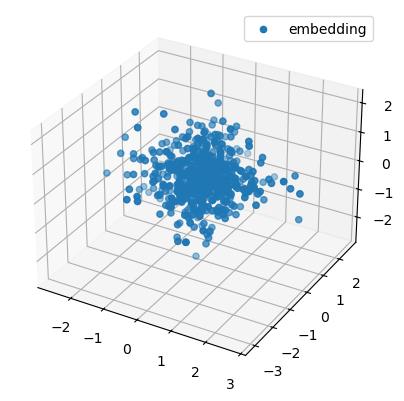

In [65]:
T_labels  # T_labels issus du Training 
trainer.model.eval()   # pas grad, pas de dropout 
with torch.no_grad():
    output = trainer.model.Tembedding(T_labels.long())

X1,Y1,Z1 = output[:,0].numpy(),output[:,1].numpy(),output[:,2].numpy()

x = np.arange(len(X1))
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(X1,Y1,Z1,label = 'embedding')
ax.legend()
plt.show()

180.93881225585938 0.955689063266307
143.93115234375 0.8975600784698382


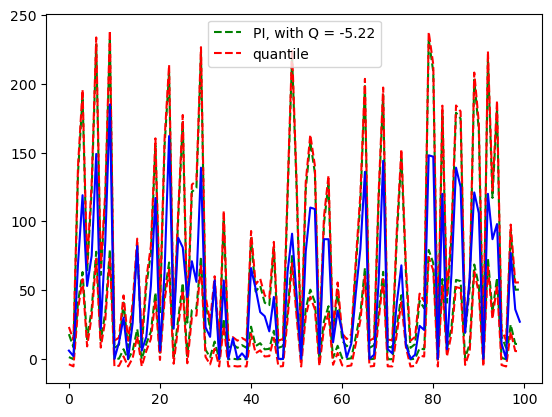

In [4]:
for training_mode in ['cal','train','validate','test']:
    print(training_mode)
    Pred_cal,Y_true_cal =trainer.test_prediction(allow_dropout = False,training_mode = 'cal')
    unorm_Pred_cal,unorm_Y_true_cal = dataset.unormalize_tensor(Pred_cal),dataset.unormalize_tensor(Y_true_cal)

    # PI 'classic' :
    pi_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, type_calib = 'classic')
    print(pi_cal.mpiw,pi_cal.picp)

    # PI 'CQR' : 
    pi_cqr_cal = PI_object(unorm_Pred_cal,unorm_Y_true_cal,alpha = args.alpha, Q = Q, type_calib = 'CQR')
    print(pi_cqr_cal.mpiw,pi_cqr_cal.picp)

    plt.plot(np.arange(100),pi_cqr_cal.upper[:100,0,0],color = 'green',linestyle = 'dashed',label = f"PI, with Q = {'{:.2f}'.format(pi_cqr_cal.Q[0,0,0].item())}")
    plt.plot(np.arange(100),pi_cqr_cal.lower[:100,0,0],color = 'green',linestyle = 'dashed')
    plt.plot(np.arange(100),pi_cal.upper[:100,0,0],color = 'red',linestyle = 'dashed',label = 'quantile')
    plt.plot(np.arange(100),pi_cal.lower[:100,0,0],color = 'red',linestyle = 'dashed')
    plt.plot(np.arange(100),unorm_Y_true_cal[:100,0,0],color = 'blue')
    plt.legend()

In [14]:
# PI des quantiles est trop large (97%). Donc, Q devrait être négatif 
model = trainer.model
model.eval()
with torch.no_grad():
    data = [[x_b,y_b] for  x_b,y_b in trainer.dataloader['cal']]
    X_cal,Y_cal = torch.cat([x_b for [x_b,y_b] in data]),torch.cat([y_b for [x_b,y_b] in data])
    preds = model(X_cal) # x_cal is normalized

    # get lower and upper band
    if preds.size(-1) == 2:
        lower_q,upper_q = preds[...,0].unsqueeze(-1),preds[...,1].unsqueeze(-1)   # The Model return ^q_l and ^q_u associated to x_b

    elif preds.size(-1) == 1:
        lower_q,upper_q = preds,preds 
    else:
        raise ValueError(f"Shape of model's prediction: {preds.size()}. Last dimension should be 1 or 2.")
    
    # unormalized lower band, upper band, and Y_cal 
    lower_q, upper_q = dataset.unormalize_tensor(lower_q),dataset.unormalize_tensor(upper_q)
    Y_cal = dataset.unormalize_tensor(Y_cal)

    # Confority scores and quantiles
    if args.conformity_scores_type == 'max_residual':
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function
    if args.conformity_scores_type == 'max_residual_plus_middle':
        print("|!| Conformity scores computation is not based on 'max(ql-y, y-qu)'")
        conformity_scores = torch.max(lower_q-Y_cal,Y_cal-upper_q) + ((lower_q>Y_cal)(upper_q<Y_cal))*(upper_q - lower_q)/2  # Element-wise maximum        #'max(lower_q-y_b,y_b-upper_q)' is the quantile regression error function 

    quantile_order = torch.Tensor([np.ceil((1 - args.alpha)*(X_cal.size(0)+1))/X_cal.size(0)])
    Q = torch.quantile(conformity_scores, quantile_order, dim = 0) #interpolation = 'higher'

In [15]:
lower_q[:10,0,0],upper_q[:10,0,0],Y_cal[:10,0,0]

(tensor([ 27.0295,   2.3823, -10.6389, -11.9061, -11.9061,  -8.5437,  33.5009,
          41.8354,  46.4636, -12.4527]),
 tensor([177.8735,  67.0889,  53.7768,  37.4192,  37.4192,  36.1508, 213.2399,
         254.6087, 287.3973,  38.0547]),
 tensor([124.,  27.,  39.,   0.,   0.,  31., 109., 106., 121.,   4.]))

0.36081740260124207 0.9917475728155339


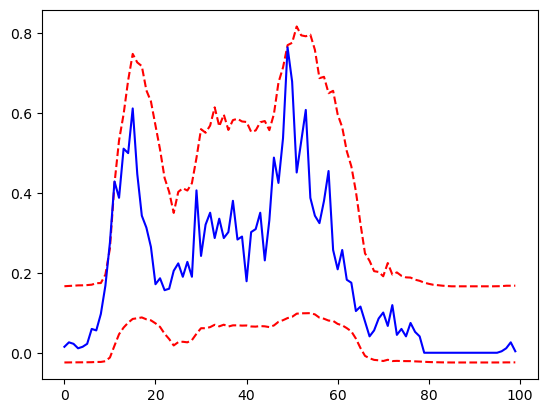

In [12]:
Pred_test,Y_true_test =trainer.test_prediction(allow_dropout = False,training_mode = 'test')
pi_test = PI_object(Pred_test,Y_true_test,alpha = args.alpha, type_calib = 'classic')
print(pi_test.mpiw,pi_test.picp)

plt.plot(np.arange(100),Pred_test[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_test[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_test[:100,0,0],color = 'blue')

0.34379279613494873 0.9918358340688438


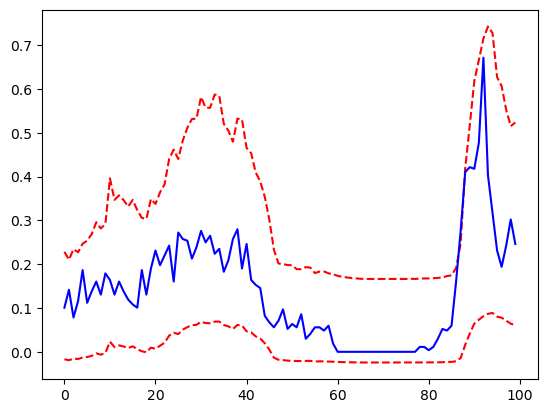

In [14]:
Pred_valid,Y_true_valid =trainer.test_prediction(allow_dropout = False,training_mode = 'validate')
pi_valid = PI_object(Pred_valid,Y_true_valid,alpha = args.alpha, type_calib = 'classic')
print(pi_valid.mpiw,pi_valid.picp)

plt.plot(np.arange(100),Pred_valid[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_valid[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_valid[:100,0,0],color = 'blue')

0.34810584783554077 0.9901325478645067


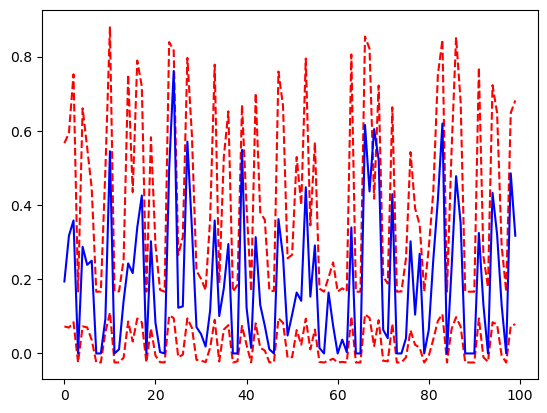

In [23]:
Pred_train,Y_true_train =trainer.test_prediction(allow_dropout = False,training_mode = 'train')
pi_train = PI_object(Pred_train,Y_true_train,alpha = args.alpha, type_calib = 'classic')
print(pi_train.mpiw,pi_train.picp)

plt.plot(np.arange(100),Pred_train[:100,0,0],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Pred_train[:100,0,1],color = 'red',linestyle = 'dashed')
plt.plot(np.arange(100),Y_true_train[:100,0,0],color = 'blue')

A priori, ça ne sert à rien de les projeté dans un espace de plus grande dimension.
- J'ai un ensemble de 'mot'. Chaque mot correspond a une combinaison (d,h,m).
- Il y a 7 jours, 24h, 4 time-step de minute (0,15,30,45). Donc j'ai un ensemble de 4*7*24 = 672 mots.
- J'aimerais faire un embedding de ces mots. C'est a dire représenter chaque mot par un vecteur. 

Exemple : 
(0,7,0) est 'Lundi 8h15'. J'en fais un embedding (donc une projection) dans un espace latent (exemple en dimension 3):


**Problème** : très peu d'occurence de chacun des 'mots' (En tout une semaine pour balayer une seule fois chaucn des mots possible. Donc 1 an de Training c'est seulement 57 apparitions...)